In [1]:
import random
import itertools
import functools
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


import gudhi as gd
import torch
torch.set_default_dtype(torch.float64) 
import torch.nn as nn

---
> DATA PREPARATION:
- GENERATE POINT CLOUDS
- COMPUTE PERSISTENCE 0 AND 1
- PREPARE BARS LIKE 'vecs'
- SPLIT IN TRAIN AND TEST SET

> BUILD THE NN USING L_INF LAYERS
- INIT THE LAYER
- CREATE THE MODEL WITH A CUSTOM NUMBER OF LAYERS

> TEST THE MODEL
- BUILD THE TEST FUNCTION
- TRAINING WITH EPOCHS
- TRAIN AND TEST ACCURACY

---
> DATA PREPARATION

In [2]:
# I WANT TO COMPARE CLOUDS WITH 1K POINTS WITH THE SAME STARTING POINT
def generate_orbits(n_points_per_orbit = 1000, params = [2.5, 3.5, 4.0, 4.1, 4.3], same_init_point = True):
    # create point clouds 
    ORBITS = np.zeros([len(params), n_points_per_orbit, 2])
    xcur_0, ycur_0 = np.random.rand(), np.random.rand() # not necesary to save the first one
    for id_pc, param in enumerate(params): # id_point_cloud
        if same_init_point:
            xcur, ycur = xcur_0, ycur_0 # not necesary to save the first one
        else:
            xcur, ycur =np.random.rand(), np.random.rand()
        for id_pt in range(n_points_per_orbit): # id_point
            xcur = (xcur + param * ycur * (1. - ycur)) % 1
            ycur = (ycur + param * xcur * (1. - xcur)) % 1
            ORBITS[id_pc, id_pt, :] = [xcur, ycur]
    return ORBITS

# function from [len(params), n_points, 2] to alpha-complex and persistence diagram
# to create PDs we need to: points -> skeleton(ac) -> simplex(st) -> persistence(pers)
# for each element of the dataset we'll have len(params) PDs to be compared
def extract_PD(cloud, id_class):
    """extract a dict 

    Args:
        cloud (_type_): array [1000,2] composing th ewhole point cloud
        id_class (_type_): index about the class of membership

    Returns:
        dict: with keys ['persist_0','persist_1','id_class']
    """
    # for every point cloud we create a dictionary storing the label and its persistence
    # usage of dictionary to store each other possible data linked to the point clous
    ac = gd.AlphaComplex(points=cloud)
    st = ac.create_simplex_tree()
    pers = st.persistence()
    
    #! TRANSPOSE TO HAVE THEN [BATCH SIZE, 2, NUM POINTS]
    pers_0 = np.array(st.persistence_intervals_in_dimension(0)).transpose()
    pers_1 = np.array(st.persistence_intervals_in_dimension(1)).transpose()
    pers_dict = {
        'persist_0': pers_0[:,:-1], # removing the last barcode, the one with inf
        'persist_1': pers_1, # here we should never have inf, since [0,1]^2 is compact/bounded  
        'persist': pers, # actual PD
        'id_class': id_class # label for classification
    }
    return pers_dict

# def gaussian_transformation(pd):
#     # Apply the function along the rows
#     embs = np.apply_along_axis(gamma_p, axis=1, arr=pd)
#     return torch.tensor(embs)

# def gamma_p(p):
#     # params of gaussian_transformation
#     ts = torch.tensor([[0., 0.], \
#           [0.25, 0.], [0.25, 0.25], \
#           [0.5, 0.], [0.5, 0.25], [0.5, 0.5], \
#           [0.75, 0.], [0.75, 0.25], [0.75, 0.5], [0.75, 0.75], \
#           [1., 0.], [1., 0.25], [1., 0.5], [1., 0.75], [1., 1.]])
#     sigma = 0.2
#     # single point computaions for gaussian transformation
#     squared_distances = torch.pow(ts - p, 2).sum(dim=1)
#     emb = -squared_distances/(2*sigma**2)
#     emb = torch.exp(emb)
#     return emb

In [3]:
# hyper params
n_points = 1000
params = [2.5, 3.5, 4.0, 4.1, 4.3]
same_init_point = True
n_seq_per_dataset = [700, 300] # [size train, size test] for each class

extended_pers = False # to be implemented, at the moment not interested in

# init list fo persistence diagrams
pds_train = []
pds_test = []

# TRAIN 
for i in tqdm(range(n_seq_per_dataset[0]), desc='Create TRAIN Point Clouds'):
    ORBS = generate_orbits(n_points, params, same_init_point) # CREATE THE 5 POINT CLOUDS
    for j in range(ORBS.shape[0]):
        ij_pers = extract_PD(ORBS[j,:,:], j) # EXTRACT PDs
        pds_train.append(ij_pers) # STORE IN THE LIST pds_train

# TEST
for i in tqdm(range(n_seq_per_dataset[1]), desc='Create TEST Point Clouds'):
    ORBS = generate_orbits(n_points, params, same_init_point) # CREATE THE 5 POINT CLOUDS
    for j in range(ORBS.shape[0]):
        ij_pers = extract_PD(ORBS[j,:,:], j) # EXTRACT PDs
        pds_test.append(ij_pers) # STORE IN THE LIST pds_test

Create TEST Point Clouds: 100%|██████████| 300/300 [00:17<00:00, 17.28it/s]


Creation of H0 and H1 both for train and test:

> Sorting persistences barcodes by length (no contours aplied yet)

> np.arrays of sizes ['num of total diagrams in the dataset','number of barcodes in the diagram']

> Save respective target classes

> Restrict to number of bars equals to 'preproc_size' in each diagram

> Divide in batch

In [4]:
num_dgs_train = len(pds_train)
num_dgs_test = len(pds_test)

# train
# todo: HERE I WANT ALSO TO APPLY A DENSITY IN SOME CASES 
barlength_train_H0 = np.array([np.sort(pds_train[i]['persist_0'][1] - pds_train[i]['persist_0'][0]) for i in range(num_dgs_train)]) # length of barcodes H0 (size always =999)
# todo: 
barlength_train_H1 = [np.sort(pds_train[i]['persist_1'][1] - pds_train[i]['persist_1'][0]) for i in range(num_dgs_train)] # length of barcodes H0 (size always =999)
# test
# todo: 
barlength_test_H0 = np.array([np.sort(pds_test[i]['persist_0'][1] - pds_test[i]['persist_0'][0]) for i in range(num_dgs_test)]) # length of barcodes H0 (size always =999)
# todo: 
barlength_test_H1 = [np.sort(pds_test[i]['persist_1'][1] - pds_test[i]['persist_1'][0]) for i in range(num_dgs_test)] # length of barcodes H0 (size always =999)

max_size_H0 = 999
max_size_train_H1 = max([i.shape[0] for i in barlength_train_H1])
print(f'{max_size_train_H1 = }')
max_size_test_H1 = max([i.shape[0] for i in barlength_test_H1])
print(f'{max_size_test_H1 = }')

# H0 TRAIN
train_vecs_H0 = np.zeros((num_dgs_train, max_size_H0))
for i in range(num_dgs_train):
    train_vecs_H0[i, :barlength_train_H0[i].shape[0]] = barlength_train_H0[i][::-1]

# H1 TRAIN
train_vecs_H1 = np.zeros((num_dgs_train, max_size_train_H1))
for i in range(num_dgs_train):
    train_vecs_H1[i, :barlength_train_H1[i].shape[0]] = barlength_train_H1[i][::-1]

# H0 TEST
test_vecs_H0 = np.zeros((num_dgs_test, max_size_H0))
for i in range(num_dgs_test):
    test_vecs_H0[i, :barlength_test_H0[i].shape[0]] = barlength_test_H0[i][::-1]

test_vecs_H1 = np.zeros((num_dgs_test, max_size_test_H1))
for i in range(num_dgs_test):
    test_vecs_H1[i, :barlength_test_H1[i].shape[0]] = barlength_test_H1[i][::-1]

max_size_train_H1 = 1021
max_size_test_H1 = 1013


In [5]:
train_vecs_H0.shape, train_vecs_H1.shape, test_vecs_H0.shape, test_vecs_H1.shape

((3500, 999), (3500, 1021), (1500, 999), (1500, 1013))

In [6]:
train_classes = np.array([pds_train[i]['id_class'] for i in range(num_dgs_train)])
test_classes = np.array([pds_test[i]['id_class'] for i in range(num_dgs_test)])
train_classes.shape, test_classes.shape

((3500,), (1500,))

In [7]:
preproc_size = 750
train_vecs_H0 = train_vecs_H0[:,:preproc_size]*100 ##* TEMPERATURE??
train_vecs_H1 = train_vecs_H1[:,:preproc_size]*100
test_vecs_H0 = test_vecs_H0[:,:preproc_size]*100
test_vecs_H1 = test_vecs_H1[:,:preproc_size]*100

In [8]:
batch_size = 256
n_train_batches = len(train_vecs_H0)//batch_size + 1
batched_train = []
for i in range(n_train_batches):
    batched_train.append(\
        [torch.tensor(train_vecs_H0[i*batch_size:(i+1)*batch_size,:]),\
        torch.tensor(train_vecs_H1[i*batch_size:(i+1)*batch_size,:]),\
        torch.tensor(train_classes[i*batch_size:(i+1)*batch_size])])
    
n_test_batches = len(test_vecs_H0)//batch_size + 1
batched_test = []
for i in range(n_test_batches):
    batched_test.append(\
        [torch.tensor(test_vecs_H0[i*batch_size:(i+1)*batch_size,:]),\
        torch.tensor(test_vecs_H1[i*batch_size:(i+1)*batch_size,:]),\
        torch.tensor(test_classes[i*batch_size:(i+1)*batch_size])])

In [9]:
# for i in batched_test:
#     print(i[0].shape)
n_train_batches, n_test_batches

(14, 6)

----------------------------------------
> BUILD THE NN USING L_INF LAYERS

Until now I'm trying without normalization, so all layers are equal.
Now I've tried without, but I agree with the fact that we should find a good one and that the initialization should be done only on the training set.
I'll try with scaling starting from the mean and sd of data. 

In [10]:
class linfLayer(nn.Module):
    def __init__(self, in_blocks, out_blocks, layer_num):
        super().__init__()
        self.layer_num = layer_num
        
        params = torch.randn((out_blocks, in_blocks)) * 0.05
        self.params = torch.nn.Parameter(data=params)

    def forward(self, x, p):
        res = torch.cdist(x, self.params, p=p) #torch.cdist but with custom params
        return res

Size of following layers are based on try and error, nothing more

In [11]:
class linfModel(nn.Module):
    def __init__(self, preproc_size):
        super().__init__()

        self.layer1_H0 = linfLayer(in_blocks=preproc_size, out_blocks=800, layer_num=1)
        self.layer2_H0 = linfLayer(in_blocks=800, out_blocks=400, layer_num=2)
        self.layer3_H0 = linfLayer(in_blocks=400, out_blocks=100, layer_num=3)
        self.layer4_H0 = linfLayer(in_blocks=100, out_blocks=50, layer_num=3)

        self.layer1_H1 = linfLayer(in_blocks=preproc_size, out_blocks=800, layer_num=1)
        self.layer2_H1 = linfLayer(in_blocks=800, out_blocks=400, layer_num=2)
        self.layer3_H1 = linfLayer(in_blocks=400, out_blocks=100, layer_num=3)
        self.layer4_H1 = linfLayer(in_blocks=100, out_blocks=50, layer_num=3)

        self.layer1_output = linfLayer(in_blocks=100, out_blocks=120, layer_num=1)
        self.layer2_output = linfLayer(in_blocks=120, out_blocks=80, layer_num=1)
        self.layer3_output = linfLayer(in_blocks=80, out_blocks=30, layer_num=1)
        self.layer4_output = linfLayer(in_blocks=30, out_blocks=5, layer_num=1)

    def forward(self, h0, h1, p):
        B = h0.shape[0]
        h0 = self.layer1_H0(h0, p)
        h0 = h0 - h0.mean(axis=0)
        h0 = self.layer2_H0(h0, p)
        h0 = h0 - h0.mean(axis=0)
        h0 = self.layer3_H0(h0, p)
        h0 = h0 - h0.mean(axis=0)
        h0 = self.layer4_H0(h0, p)
        
        h1 = self.layer1_H1(h1, p)
        h1 = h1 - h1.mean(axis=0)
        h1 = self.layer2_H1(h1, p)
        h1 = h1 - h1.mean(axis=0)
        h1 = self.layer3_H1(h1, p)
        h1 = h1 - h1.mean(axis=0)
        h1 = self.layer4_H1(h1, p)

        concat = torch.cat((h0.view(B, -1), h1.view(B, -1)), dim = 1)
        output = self.layer1_output(concat, p)
        output = output - output.mean(axis=0)
        output = self.layer2_output(output, p)
        output = output - output.mean(axis=0)
        output = self.layer3_output(output, p)
        output = output - output.mean(axis=0)
        output = self.layer4_output(output, p)

        return -output

    def get_embs(self, x, p):
        x = self.layer1(x, p)
        x = x - x.mean(axis=0)
        #x = self.layer2(x, p)
        return x

Here I try the mixed network mentioned in the paper: $L_\infty$ Dist layers + Linears

I tried and saw that with two linears it doesn't work properly, so, the tanh and the second linear are commmented.

In [12]:
class LinfModel_MIXED(nn.Module):
    def __init__(self, preproc_size):
        super().__init__()

        self.layer1_H0 = linfLayer(in_blocks=preproc_size, out_blocks=800, layer_num=1)
        self.layer2_H0 = linfLayer(in_blocks=800, out_blocks=400, layer_num=2)
        self.layer3_H0 = linfLayer(in_blocks=400, out_blocks=100, layer_num=3)
        self.layer4_H0 = linfLayer(in_blocks=100, out_blocks=50, layer_num=3)

        self.layer1_H1 = linfLayer(in_blocks=preproc_size, out_blocks=800, layer_num=1)
        self.layer2_H1 = linfLayer(in_blocks=800, out_blocks=400, layer_num=2)
        self.layer3_H1 = linfLayer(in_blocks=400, out_blocks=100, layer_num=3)
        self.layer4_H1 = linfLayer(in_blocks=100, out_blocks=50, layer_num=3)

        self.layer1_output = linfLayer(in_blocks=100, out_blocks=120, layer_num=1)
        self.layer2_output = linfLayer(in_blocks=120, out_blocks=80, layer_num=1)
        self.layer3_output = nn.Linear(80,30)
        self.layer4_output = nn.Linear(30,5)

    def forward(self, h0, h1, p):
        B = h0.shape[0]
        h0 = self.layer1_H0(h0, p)
        h0 = h0 - h0.mean(axis=0)
        h0 = self.layer2_H0(h0, p)
        h0 = h0 - h0.mean(axis=0)
        h0 = self.layer3_H0(h0, p)
        h0 = h0 - h0.mean(axis=0)
        h0 = self.layer4_H0(h0, p)
        
        h1 = self.layer1_H1(h1, p)
        h1 = h1 - h1.mean(axis=0)
        h1 = self.layer2_H1(h1, p)
        h1 = h1 - h1.mean(axis=0)
        h1 = self.layer3_H1(h1, p)
        h1 = h1 - h1.mean(axis=0)
        h1 = self.layer4_H1(h1, p)

        concat = torch.cat((h0.view(B, -1), h1.view(B, -1)), dim = 1)
        output = self.layer1_output(concat, p)
        output = output - output.mean(axis=0)
        output = self.layer2_output(output, p)
        output = self.layer3_output(output)
        # output = torch.tanh(output)
        # output = self.layer4_output(output)

        return output

----------------------------------------
> TEST THE MODEL

I'm reaching 80% of accuracy with both models

In [76]:
epochs = 100
inf=float("inf")

p_schedule = np.ones(epochs)*inf

# e1, e2 = 20,40 # e1+e2 < epochs !!
# p_schedule = np.ones(epochs)*8
# p_schedule[e1:e1+e2] = np.linspace(8, 100, e2)
# p_schedule[e1+e2:] = inf

save_folder = f'./LinfModels/'

In [1]:
def test_model(model, test_data, if_plot):
    # Set the model to evaluation mode
    model.eval()

    target_labs = np.array([])
    pred_labs = np.array([])
    correct = 0
    total = 0

    # Disable gradient calculation
    with torch.no_grad():
        # for batch in tqdm(test_data):
        for (h0, h1, cl) in test_data:

            # Forward pass
            outputs = model(h0, h1, p_schedule[i])
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels
            total += cl.size(0)
            # Total correct predictions
            correct += (predicted == cl).sum().item()
            target_labs = np.append(target_labs, cl)
            pred_labs = np.append(pred_labs, predicted)

    # Calculate accuracy
    accuracy = 100 * correct / total
    # print('Accuracy on the test set: {:.2f}%'.format(accuracy))

    if if_plot:
        cm = confusion_matrix(np.array(target_labs), np.array(pred_labs))
        classes = [1,2,3,4,5]
        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()
        
    return accuracy

Epoch   1/100 --> IMPROVEMENT from 0.000 to 65.467 	
Epoch   2/100 --> IMPROVEMENT from 65.467 to 69.533 	
Epoch   8/100 --> IMPROVEMENT from 69.533 to 69.933 	
Epoch  10/100 --> IMPROVEMENT from 69.933 to 70.400 	
Epoch  14/100 --> IMPROVEMENT from 70.400 to 70.600 	
Epoch  17/100 --> IMPROVEMENT from 70.600 to 71.267 	
Epoch  22/100 --> IMPROVEMENT from 71.267 to 71.600 	
Epoch  23/100 --> IMPROVEMENT from 71.600 to 71.800 	
Epoch  38/100 --> IMPROVEMENT from 71.800 to 71.867 	
Epoch  76/100 --> IMPROVEMENT from 71.867 to 72.200 	
 Epoch 100	loss : 1.21122, p: inf

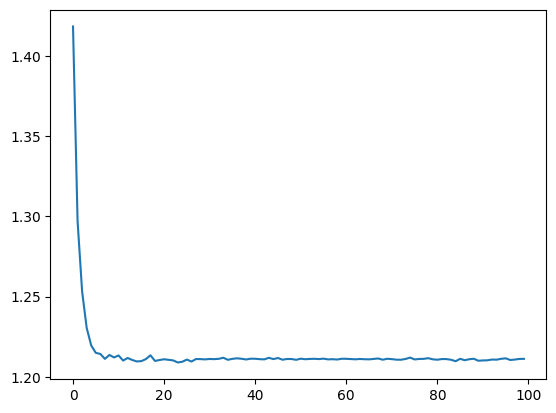

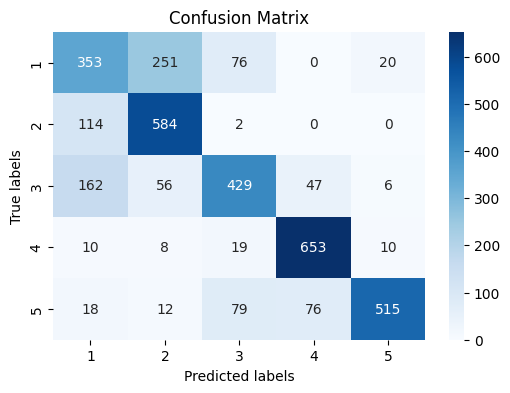

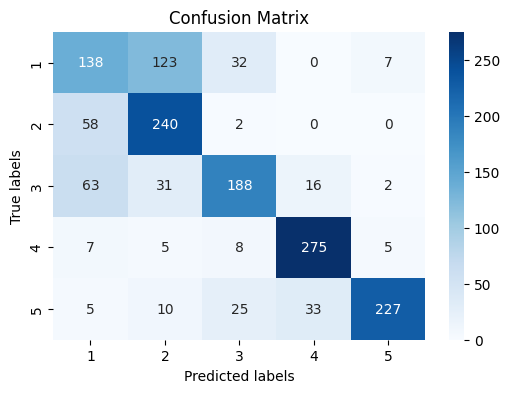

(72.4, 71.2)

In [78]:
# Model , Optimizer, Loss
model = linfModel(preproc_size)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.05, eps=1e-06)
# list(model.parameters())[0].shape
losses = []
best_acc = 0.0

for i in range(epochs):
    for (h0, h1, cl) in batched_train:
        model.train()
        tot_loss = 0.0
        
        #calculate output
        output = model(h0, h1, p_schedule[i])

        #calculate loss
        loss = loss_fn(output, cl.long())

        #backprop
        optimizer.zero_grad()
        tot_loss += float(loss)
        loss.backward()
        optimizer.step()
    
    losses.append(tot_loss)
    test_acc = test_model(model, batched_test, if_plot=False)
    if best_acc < test_acc:
        if test_acc > 80.0:
            torch.save(model.state_dict(), save_folder + f'PURE_{preproc_size}_acc_{test_acc:.3f}.pth')
        print(f'\rEpoch {i+1:3}/{epochs} --> IMPROVEMENT from {best_acc:.3f} to {test_acc:.3f} \t')
        best_acc = test_acc
    else:
        # print(f'> Test Accuracy = {test_acc} [best = {best_acc}]')
        print(f"\r Epoch {i+1:3}\tloss : {loss:.5f}, p: {p_schedule[i]}", end='')

plt.plot(np.array(losses))
train_acc = test_model(model, batched_train, if_plot=True)
test_acc = test_model(model, batched_test, if_plot=True)
train_acc, test_acc

Epoch   1/100 --> IMPROVEMENT from 0.000 to 62.667 	
Epoch   2/100 --> IMPROVEMENT from 62.667 to 74.400 	
Epoch   3/100 --> IMPROVEMENT from 74.400 to 75.600 	
Epoch   5/100 --> IMPROVEMENT from 75.600 to 76.933 	
Epoch   6/100 --> IMPROVEMENT from 76.933 to 77.067 	
Epoch  15/100 --> IMPROVEMENT from 77.067 to 77.467 	
Epoch  20/100 --> IMPROVEMENT from 77.467 to 78.067 	
Epoch  25/100 --> IMPROVEMENT from 78.067 to 78.133 	
Epoch  29/100 --> IMPROVEMENT from 78.133 to 78.533 	
Epoch  35/100 --> IMPROVEMENT from 78.533 to 79.000 	
Epoch  38/100 --> IMPROVEMENT from 79.000 to 79.600 	
Epoch  50/100 --> IMPROVEMENT from 79.600 to 79.800 	
Epoch  59/100 --> IMPROVEMENT from 79.800 to 79.867 	
Epoch  66/100 --> IMPROVEMENT from 79.867 to 80.067 	
Epoch  78/100 --> IMPROVEMENT from 80.067 to 80.133 	
Epoch  79/100 --> IMPROVEMENT from 80.133 to 80.800 	
 Epoch 100	loss : 0.57275, p: inf

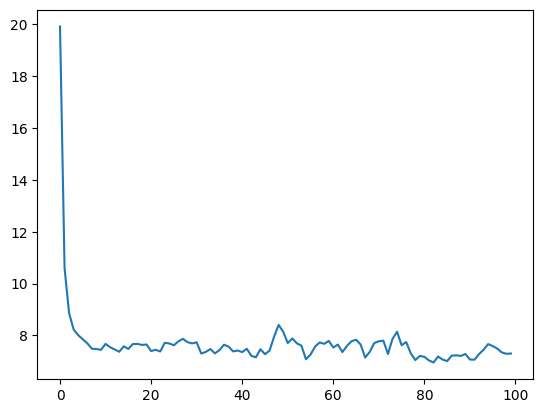

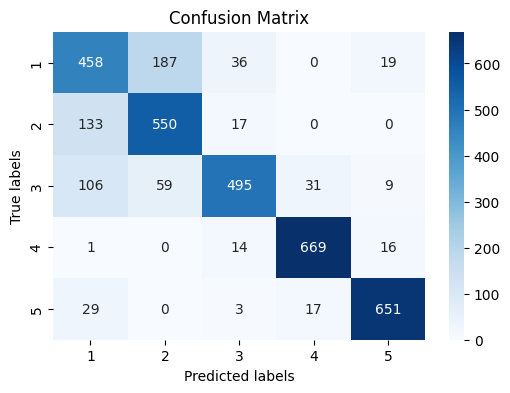

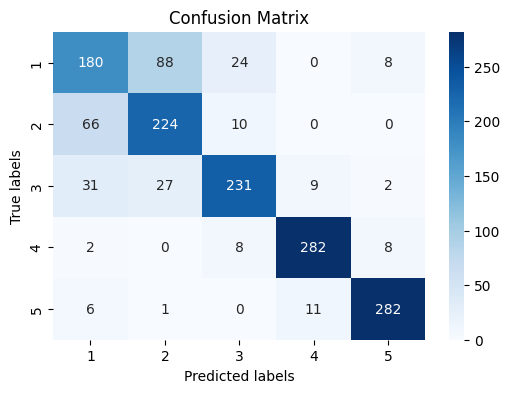

(80.65714285714286, 79.93333333333334)

In [79]:
# Model , Optimizer, Loss
model = LinfModel_MIXED(preproc_size)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.05, eps=1e-06)
# list(model.parameters())[0].shape
losses = []
best_acc = 0.0

for i in range(epochs):
    model.train()
    tot_loss = 0.0
    for (h0, h1, cl) in batched_train:

        #calculate output
        output = model(h0, h1, p_schedule[i])

        #calculate loss
        loss = loss_fn(output, cl.long())

        #backprop
        optimizer.zero_grad()
        tot_loss += float(loss)
        loss.backward()
        optimizer.step()
    
    losses.append(tot_loss)
    test_acc = test_model(model, batched_test, if_plot=False)
    if best_acc < test_acc:
        if test_acc > 80.0:
            torch.save(model.state_dict(), save_folder + f'MIX_{preproc_size}_acc_{test_acc:.3f}.pth')
        print(f'\rEpoch {i+1:3}/{epochs} --> IMPROVEMENT from {best_acc:.3f} to {test_acc:.3f} \t')
        best_acc = test_acc
    else:
        # print(f'> Test Accuracy = {test_acc} [best = {best_acc}]')
        print(f"\r Epoch {i+1:3}\tloss : {loss:.5f}, p: {p_schedule[i]}", end='')

plt.plot(np.array(losses))
train_acc = test_model(model, batched_train, if_plot=True)
test_acc = test_model(model, batched_test, if_plot=True)
train_acc, test_acc

---
> OUTPUT INSPECTION

- Usinf Lip-layers, distance between NN representations should never be larger than the distance between stable ranks
- Margin computation for the  

In [56]:
# to load a proper model saved in the folder 'save_folder'
model_str = save_folder + 'PURE_750_acc_80.133.pth'
saved_params = torch.load(model_str)
model.load_state_dict(saved_params)

<All keys matched successfully>

In [80]:
data_H0 = torch.tensor(test_vecs_H0)
data_H1 = torch.tensor(test_vecs_H1)
data_H0.shape, data_H1.shape

(torch.Size([1500, 750]), torch.Size([1500, 750]))

In [81]:
model.eval()
test_output = model(data_H0, data_H1, inf)
test_output.shape, test_output

(torch.Size([1500, 30]),
 tensor([[ 24.5582,  21.5059,  23.0099,  ..., -32.6147, -32.8110, -34.0686],
         [ 23.2127,  24.9800,  22.1065,  ..., -32.1577, -32.3956, -33.5056],
         [ 23.8605,  21.0920,  23.9195,  ..., -32.3226, -32.5600, -33.7980],
         ...,
         [ 19.5706,  17.3016,  25.0580,  ..., -32.4566, -32.6080, -33.8135],
         [ 19.3467,  16.9184,  23.5890,  ..., -32.4804, -32.6563, -33.6792],
         [ 23.9655,  18.7558,  24.5449,  ..., -34.3120, -34.5440, -35.9764]],
        grad_fn=<AddmmBackward0>))

In [82]:
output_sorted = torch.sort(test_output, dim=1, descending=True)[0]
output_sorted, output_sorted.shape

(tensor([[ 24.5582,  23.0099,  21.5059,  ..., -33.6903, -33.6942, -34.0686],
         [ 24.9800,  23.2127,  22.1065,  ..., -33.2014, -33.2644, -33.5056],
         [ 23.9195,  23.8605,  21.0920,  ..., -33.4262, -33.4709, -33.7980],
         ...,
         [ 27.2551,  25.0580,  21.3481,  ..., -33.6276, -33.6758, -33.8135],
         [ 27.8142,  23.7893,  23.5890,  ..., -33.6792, -33.6916, -33.7670],
         [ 27.1174,  24.5449,  23.9655,  ..., -35.5431, -35.5569, -35.9764]],
        grad_fn=<SortBackward0>),
 torch.Size([1500, 30]))

In [83]:
margin = (output_sorted[:,0] - output_sorted[:,1])
margin.shape, (margin).mean()

(torch.Size([1500]), tensor(2.5043, grad_fn=<MeanBackward0>))

Now I can perturb a bit a correctly-classified sample in the test set and check if it would be still correctly classified

In [101]:
check_example_class = test_classes[0]
check_example_H0 = data_H0[0,:]
check_example_H1 = data_H1[0,:]

In [104]:
# perturbing the sample
index = 100
check_example_H0.shape, check_example_H0.min(), check_example_H0.max()
perturbed_example_H0 = check_example_H0
perturbed_example_H0[index] = perturbed_example_H0[index]+0.002
check_example_H0[index], perturbed_example_H0[index]

(tensor(0.1044), tensor(0.1044))

Distances between all samples:
- stable ranks
- representation learned

In [85]:
tensors = torch.cat((data_H0, data_H1), dim = 1)
distMatStab_H0 = torch.cdist(data_H0, data_H0, p=inf)
distMatStab_H1 = torch.cdist(data_H1, data_H1, p=inf)
distMatRep = torch.cdist(test_output, test_output, p=inf)

In [86]:
factors = distMatRep / (distMatStab_H0 + distMatStab_H1)
factors[torch.isnan(factors)] = 0
factors, factors.mean(), factors.max()

(tensor([[ 0.0000, 16.2021,  7.7484,  ...,  7.9450,  6.8538, 10.5026],
         [16.2021,  0.0000, 15.2536,  ...,  6.3319,  5.5795, 12.4861],
         [ 7.7484, 15.2536,  0.0000,  ...,  8.0484,  6.8299, 15.1641],
         ...,
         [ 7.9450,  6.3319,  8.0484,  ...,  0.0000,  7.9867,  7.9219],
         [ 6.8538,  5.5795,  6.8299,  ...,  7.9867,  0.0000,  6.1742],
         [10.5026, 12.4861, 15.1641,  ...,  7.9219,  6.1742,  0.0000]],
        grad_fn=<IndexPutBackward0>),
 tensor(10.3845, grad_fn=<MeanBackward0>),
 tensor(43.9744, grad_fn=<MaxBackward1>))